In [1]:
import numpy as np
import matplotlib.pyplot as plt
import miepython
from astropy import units as u

from astropy.modeling import models
from astropy import units as u
import matplotlib as mpl

from scipy import special
import pandas as pd

import scipy
import matplotlib.gridspec as gridspec

micron = 1e-4 # in cm
rsun = 6.9634e10 # in cm
pc = 3.086e18 # in cm
G = 6.6743e-8 # in cgs
k = 1.3807e-16 # cgs
msun = 1.989e33 # grams
mp = 1.673e-24
h = 6.627e-27
c = 2.99e10

mpl.rcParams.update(
     {# Use mathtext, not LaTeX
     'text.usetex': False,
     'axes.formatter.use_mathtext': True,
     # Set the fonts
     'font.family': 'STIXGeneral',
     'mathtext.fontset': 'cm',
     # Use ASCII minus
     'axes.unicode_minus': False,
    'axes.linewidth':1.5
})

## Function to return the extinction cross section
def mie(w,k,r):
    x = 2*np.pi*r/w
    qext, qsca, qback, g = miepython.mie(k, x)
    return qext

## Function to return the absorption cross section
def mie_abs(w,k,r):
    x = 2*np.pi*r/w
    qext, qsca, qback, g = miepython.mie(k, x)
    return (qext - qsca)

## The Jura Model

In [2]:
'''
Function to output the Jura03 flat disk flux in mJy units with added option of including flaring, as per
C&G97 Prescription.

Twd: temperature of WD in K
rdd_in: inner radius of disk in R_WD units
rdd_out: outer radius of disk in R_WD units
dist: distance to WD in parsecs
theta: inclination angle in degrees
Rwd: radius of white dwarf in solar radius
wave: wavelength in micron where flux needs to be calculated
del_r: radial resolution for flux calculation in R_WD units
Tsub: sublimation temperature limit (K)
Mwd: mass of WD in solar mass
mu: mean atomic mass
Hbyh: Ratio of photospheric height to scale height. 
bfactor: Turn on (0) or off (1) flaring
'''
def dust_disk_othick(Twd, rdd_in, rdd_out, dist, theta, Rwd = 0.012, 
                     wave = 3.4, del_r = 0.01, Tsub = 1500.0, Mwd = 0.7, mu=2, Hbyh = 2, bfactor = 1.0):


    # convert to cgs units
    dist = dist * pc

    Rwd = Rwd * rsun

    rdd_in = rdd_in * Rwd
    rdd_out = rdd_out * Rwd
    
    wave = wave * micron

    theta = np.pi * theta / 180.0
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    
    ## Calculate Flux from the disk face
    
    # break the disk into radial segments
    riters = np.arange(rdd_in, rdd_out, del_r*Rwd)
    
    # Calculate the grazing angle using Equation 5 -- 10 in C&G97.
    Tgp = G*Mwd*msun*mu*mp/(k*Rwd)
    dda_Hbya = Hbyh * (2.0/7.0) * ((Twd/Tgp)**(4.0/7.0)) * ((riters/Rwd)**(2.0/7.0))
    grazing_angle = (0.4*Rwd/riters) #+ bfactor*dda_Hbya
    
    # Temperature for the radial annuli
    Tds = ((grazing_angle/2.0)**0.25)*((Rwd/riters)**0.5) * Twd
        
    # Selecting only those annuli for which T<Tsub
    select_no_sublime = Tds<Tsub
       
    # Calculating BB flux. Can be replaced with real spectra
    bbs = models.BlackBody(temperature=Tds*u.K)
    inten_lambdas = bbs(wave*u.cm).value * 2*np.pi*riters*(del_r*Rwd)
    
    # Calculate the total flux in erg/s/cm2/Hz
    flux_face = np.sum(inten_lambdas[select_no_sublime]) * costheta / (dist ** 2)    
    
    # Convert to mJy
    flux_mJy = flux_face * 1e26
    
    return flux_mJy


## Flux from the inner edge

In [3]:
'''
Function to calculate the Dullemond01 prescription for inner edge flux in mJy units

Twd: temperature of WD in K
Theta: Opening angle of the disk, defined as Theta = arctan(Hrim/a) (see draft for definitions)
wave: wavelength in micron where flux needs to be calculated
incl: inclination angle in degrees
Trim: temperature of rim. If 'None', will calculate from Rrim
Rrim: distance to inner rim from WD. If 'None', will calculate from Trim
Rwd: radius of white dwarf in solar radius
'''

def disk_inner_edge(Twd, Theta, incl, dist, wave = 3.4, Trim = 1000.0, Rwd = 0.012, Rrim = 'None'):
    
    dist = dist * pc
    Rwd = Rwd * rsun
    
    if Rrim == 'None':
        Rrim = Rwd*((Twd/Trim)**2)
    elif Trim == 'None':
        Rrim = Rrim*Rwd
        Trim = Twd*np.sqrt(Rwd/(1*Rrim))
    else:
        Rrim = Rrim*Rwd
        Trim = Trim
    
    wave = wave * micron
    
    delta = np.tan(Theta*np.pi/180.0)*np.tan(incl*np.pi/180.0)
    cosi = np.cos(incl*np.pi/180.0)
    
    # Evaluating Equations B1, B2, B3 in Dullemond+01
    if delta<1.0:
    
        proj_fact = cosi * (delta*np.sqrt(1.0 - delta**2) + np.arcsin(delta))
        
    else:
        
        proj_fact = (np.pi/2.0) * cosi
    
    
    bb = models.BlackBody(temperature=Trim*u.K)
    inten_lambdas = bb(wave*u.cm).value
    
    flux_face = 2.0*inten_lambdas*((Rrim/dist)**2)*proj_fact
    
    # Output flux in mJy
    return flux_face*1e26
    

## Computing the Above Functions for WD 1145+017

In [52]:
'''
Computing the above functions for WD 1145+017

Twd = 15020 K (Izquierdo+18)
dist = 146 pc (Gaia)
Thetas: for Hrim/Rwd = hz/Rwd = 0.5, 1.0, 1.5 (see paper) at a=100 Rwd. Theta = arctan(Hrim/a)

Jura model
Rin = 10 Rwd
Rout = 200 Rwd
bfactor = 0: no flaring included
'''

Rrim = 100.0
Twd = 15020
dist = 146
hrim_by_rwd = np.array([0.5, 1.0, 1.5])/Rrim
Thetas = np.arctan(hrim_by_rwd)*180.0/np.pi


thetas = np.arange(10, 90.2, 0.2)

fluxes_Theta_vary_inner_rim = []

## Flux from inner rim in W1
for Theta in Thetas:
    fluxes_theta_vary = []
    for theta in thetas:
        flux = disk_inner_edge(Twd, Theta, theta, dist, Rrim = Rrim, Trim = 1145)
        fluxes_theta_vary.append(flux)
    fluxes_Theta_vary_inner_rim.append(fluxes_theta_vary)
    
fluxes_Theta_vary_inner_rim = np.array(fluxes_Theta_vary_inner_rim)

fluxes_Theta_vary_inner_rim_w2 = []

## Flux from inner rim in W2
for Theta in Thetas:
    fluxes_theta_vary = []
    for theta in thetas:
        flux = disk_inner_edge(Twd, Theta, theta, dist, Rrim = Rrim, Trim = 1145, wave = 4.6)
        fluxes_theta_vary.append(flux)
    fluxes_Theta_vary_inner_rim_w2.append(fluxes_theta_vary)
    
fluxes_Theta_vary_inner_rim_w2 = np.array(fluxes_Theta_vary_inner_rim_w2)

## Representative flux from Jura model in W1
fluxes_theta_vary_jura = []
for theta in thetas:
    fluxes_theta_vary_jura.append(dust_disk_othick(Twd, 10, 200, dist, theta, bfactor = 0))
    
## Representative flux from Jura model in W1
fluxes_theta_vary_jura_w2 = []
for theta in thetas:
    fluxes_theta_vary_jura_w2.append(dust_disk_othick(Twd, 10, 200, dist, theta, bfactor = 0, wave = 4.6))
    

(88.0, 90.0)

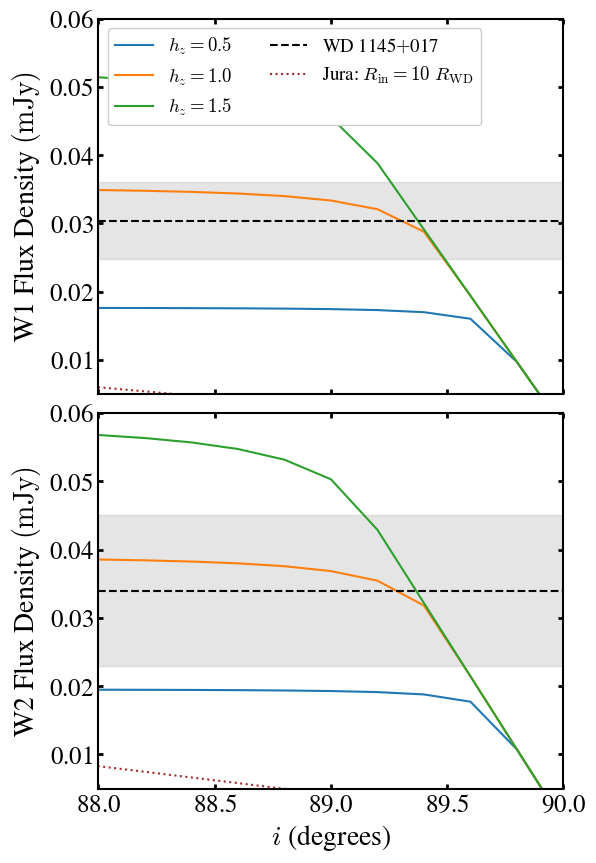

In [53]:
fig = plt.figure(figsize=(6, 10))  # Optional: adjust figure size

# Create a 2-row, 1-column GridSpec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace = 0.05)  # optional height_ratios

# Add subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# The WISE W1 Flux of WD 1145+017
wise11145_value = 0.0304
wise11145_err = 0.0056

ax1.plot(thetas, fluxes_Theta_vary_inner_rim[0,:], label = r'$h_z=0.5$')
ax1.plot(thetas, fluxes_Theta_vary_inner_rim[1,:], label = r'$h_z=1.0$')
ax1.plot(thetas, fluxes_Theta_vary_inner_rim[2,:], label = r'$h_z=1.5$')
ax1.axhline(wise11145_value, c='k', linestyle = '--', label = r'WD 1145$+$017')
ax1.set_xlim(35, 90.5)
ax1.set_ylim(0.005,0.06)

ax1.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2,
               labelbottom = False)
ax1.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

ax1.set_ylabel(r'W1 Flux Density $\rm (mJy)$', fontsize = 20)

ax1.fill_between(thetas, wise11145_value-wise11145_err, wise11145_value+wise11145_err, color='gray', alpha=0.2)
    
ax1.plot(thetas, fluxes_theta_vary_jura, linestyle = ':', c='brown', label=r'Jura: $R_{\rm in}=10~R_{\rm WD}$')

ax1.legend(fontsize = 13.5, ncols = 2, framealpha = 1, loc = 'upper left')

# The WISE W2 Flux of WD 1145+017
wise21145_value = 0.0340
wise21145_err = 0.0111

ax2.plot(thetas, fluxes_Theta_vary_inner_rim_w2[0,:], label = r'$h_z=0.5$')
ax2.plot(thetas, fluxes_Theta_vary_inner_rim_w2[1,:], label = r'$h_z=1.0$')
ax2.plot(thetas, fluxes_Theta_vary_inner_rim_w2[2,:], label = r'$h_z=1.5$')
ax2.axhline(wise21145_value, c='k', linestyle = '--', label = r'WD 1145$+$017')
ax2.set_xlim(35, 90.5)
ax2.set_ylim(0.005,0.06)

ax2.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax2.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

ax2.set_ylabel(r'W2 Flux Density $\rm (mJy)$', fontsize = 20)
ax2.set_xlabel(r'$i$ (degrees)', fontsize = 20)

ax2.fill_between(thetas, wise21145_value-wise21145_err, wise21145_value+wise21145_err, color='gray', alpha=0.2)
    
ax2.plot(thetas, fluxes_theta_vary_jura_w2, linestyle = ':', c='brown', label=r'Jura: $R_{\rm in}=10~R_{\rm WD}$')

#plt.savefig('./inner_edge_flux.png', bbox_inches='tight', dpi = 200)


## Computing the same for WD 1232+563

In [132]:
'''
Computing the above functions for WD 1232+563

Twd = 11787 K (Debes+11)
dist = 172 pc (Gaia)
Thetas: for Hrim/Rwd = hz/Rwd = 0.5, 1.0, 1.5 (see paper) at a=50 Rwd. Theta = arctan(Hrim/a)

Jura model
Rin = 7 Rwd (Debes+11)
Rout = 200 Rwd
bfactor = 0: no flaring included
Tsub = 5000.0 (exclude sublimation correction)
'''
Trim = 1000.0
Rrim = 150.0
Twd = 11787.0
dist = 172.0
hrim_by_rwd = np.array([1.0, 2, 3])/Rrim
Thetas = np.arctan(hrim_by_rwd)*180.0/np.pi

thetas = np.arange(10, 90.2, 0.2)

#### W1 ######

fluxes_Theta_vary_inner_rim = []

## Flux from inner rim
for Theta in Thetas:
    fluxes_theta_vary = []
    for theta in thetas:
        flux = disk_inner_edge(Twd, Theta, theta, dist, Rrim = Rrim, Trim = Trim)
        fluxes_theta_vary.append(flux)
    fluxes_Theta_vary_inner_rim.append(fluxes_theta_vary)
    
fluxes_Theta_vary_inner_rim = np.array(fluxes_Theta_vary_inner_rim)

## Representative flux from Jura model
fluxes_theta_vary_jura = []
for theta in thetas:
    fluxes_theta_vary_jura.append(dust_disk_othick(Twd, 7, 200, dist, theta, bfactor = 0, Tsub=5000.0))
    
#### W2 ######

fluxes_Theta_vary_inner_rim_w2 = []

## Flux from inner rim
for Theta in Thetas:
    fluxes_theta_vary = []
    for theta in thetas:
        flux = disk_inner_edge(Twd, Theta, theta, dist, Rrim = Rrim, Trim = Trim, wave = 4.6)
        fluxes_theta_vary.append(flux)
    fluxes_Theta_vary_inner_rim_w2.append(fluxes_theta_vary)
    
fluxes_Theta_vary_inner_rim_w2 = np.array(fluxes_Theta_vary_inner_rim_w2)

## Representative flux from Jura model
fluxes_theta_vary_jura_w2 = []
for theta in thetas:
    fluxes_theta_vary_jura_w2.append(dust_disk_othick(Twd, 7, 200, dist, theta, bfactor = 0, Tsub=5000.0,
                                                     wave = 4.6))
    

(88.0, 90.0)

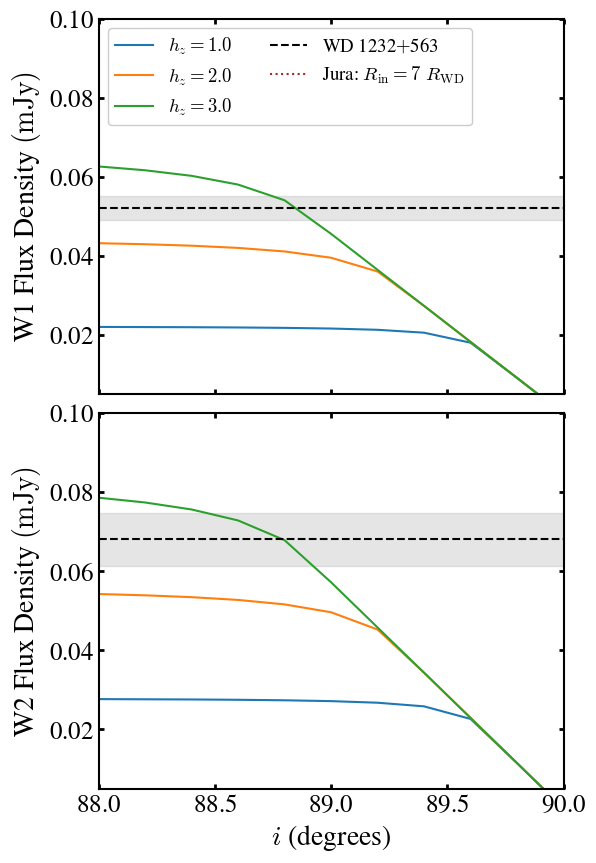

In [166]:
fig = plt.figure(figsize=(6, 10))  # Optional: adjust figure size

# Create a 2-row, 1-column GridSpec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace = 0.05)  # optional height_ratios

# Add subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# The WISE W1 Flux of WD 1232+563
wise11145_value = 0.052
wise11145_err = 0.003

ax1.plot(thetas, fluxes_Theta_vary_inner_rim[0,:], label = r'$h_z=1.0$')
ax1.plot(thetas, fluxes_Theta_vary_inner_rim[1,:], label = r'$h_z=2.0$')
ax1.plot(thetas, fluxes_Theta_vary_inner_rim[2,:], label = r'$h_z=3.0$')
#ax1.plot(thetas, fluxes_Theta_vary_inner_rim[3,:], label = r'$h_z=1.5$')
ax1.axhline(wise11145_value, c='k', linestyle = '--', label = r'WD 1232$+$563')
ax1.set_xlim(35, 90.5)
ax1.set_ylim(0.005,0.1)

ax1.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2,
               labelbottom = False)
ax1.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

ax1.set_ylabel(r'W1 Flux Density $\rm (mJy)$', fontsize = 20)

ax1.fill_between(thetas, wise11145_value-wise11145_err, wise11145_value+wise11145_err, color='gray', alpha=0.2)
    
ax1.plot(thetas, fluxes_theta_vary_jura, linestyle = ':', c='brown', label=r'Jura: $R_{\rm in}=7~R_{\rm WD}$')

ax1.legend(fontsize = 13.5, ncols = 2, framealpha = 1, loc = 'upper left')

# The WISE W2 Flux of WD 1232+563
wise21145_value = 0.068
wise21145_err = 0.0066

ax2.plot(thetas, fluxes_Theta_vary_inner_rim_w2[0,:], label = r'$h_z=1.0$')
ax2.plot(thetas, fluxes_Theta_vary_inner_rim_w2[1,:], label = r'$h_z=2.0$')
ax2.plot(thetas, fluxes_Theta_vary_inner_rim_w2[2,:], label = r'$h_z=3.0$')
ax2.axhline(wise21145_value, c='k', linestyle = '--', label = r'WD 1145$+$017')
ax2.set_xlim(35, 90.5)
ax2.set_ylim(0.005,0.1)

ax2.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax2.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

ax2.set_ylabel(r'W2 Flux Density $\rm (mJy)$', fontsize = 20)
ax2.set_xlabel(r'$i$ (degrees)', fontsize = 20)

ax2.fill_between(thetas, wise21145_value-wise21145_err, wise21145_value+wise21145_err, color='gray', alpha=0.2)
    
ax2.plot(thetas, fluxes_theta_vary_jura_w2, linestyle = ':', c='brown')

ax1.set_xlim(88, 90)
ax2.set_xlim(88, 90)

#plt.savefig('./inner_edge_flux_wd1232.png', bbox_inches='tight', dpi = 200)


## Parameter Study for Inner Edge Flux

In [178]:
Rrims = np.linspace(50.0, 300.0, 25)

thetas = np.arange(70, 90.1, 0.1)

fluxes_Rrim_vary_inner_rim = []

dist = 150.0

## Flux from inner rim
for Rrim in Rrims:
    
    Theta = np.arctan(1.0/Rrim)*180.0/np.pi
        
    for theta in thetas:
        flux = disk_inner_edge(1e4, Theta, theta, dist, Rrim = Rrim, Trim = 1200.0, wave = 3.4)
        fluxes_theta_vary.append(flux)
    fluxes_Rrim_vary_inner_rim.append(np.max(fluxes_theta_vary))
    
fluxes_Rrim_vary_inner_rim = np.array(fluxes_Rrim_vary_inner_rim)



fluxes_Rrim_vary_inner_rim_twd = []

dist = 150.0

## Flux from inner rim
for Rrim in Rrims:
    
    Theta = np.arctan(1.0/Rrim)*180.0/np.pi
    
    fluxes_theta_vary = []
    for theta in thetas:
        flux = disk_inner_edge(1.5e4, Theta, theta, dist, Rrim = Rrim, Trim = 'None', wave = 3.4)
        fluxes_theta_vary.append(flux)
    fluxes_Rrim_vary_inner_rim_twd.append(np.max(fluxes_theta_vary))
    
fluxes_Rrim_vary_inner_rim_twd = np.array(fluxes_Rrim_vary_inner_rim_twd)


In [144]:
print(fluxes_Rrim_vary_inner_rim)

[0.00959982 0.01059074 0.01158166 0.0125726  0.01356353 0.01455447
 0.01554539 0.01653635 0.0175273  0.01851823 0.01950918 0.02050014
 0.02149109 0.02248203 0.02347299 0.02446396 0.02545492 0.02644587
 0.02743681 0.02842779 0.02941873 0.0304097  0.03140066 0.03239161
 0.03338258 0.03437353 0.03536449 0.03635546 0.03734639 0.03833739
 0.0393283  0.0403193  0.04131026 0.04230117 0.04329219 0.04428314
 0.04527405 0.04626506 0.04725603 0.04824695 0.04923793 0.05022892
 0.05121987 0.05221078 0.05320178 0.05419277 0.05518372 0.05617464
 0.05716561 0.05815661]


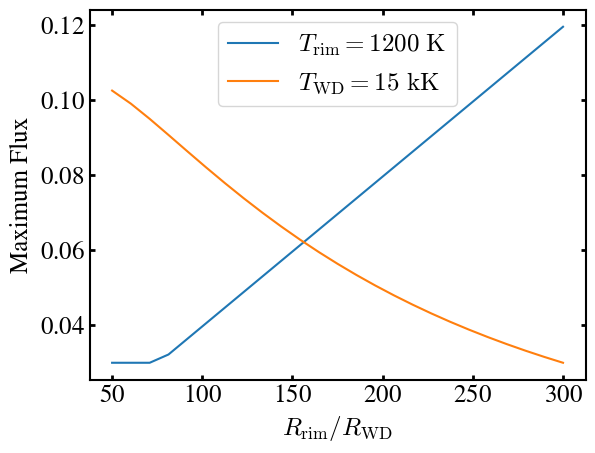

In [181]:
plt.plot(Rrims, fluxes_Rrim_vary_inner_rim, label = r'$T_{\rm rim}=1200~\rm K$')
plt.plot(Rrims, fluxes_Rrim_vary_inner_rim_twd, label = r'$T_{\rm WD}=15~\rm kK$')

plt.legend(fontsize = 18)

plt.gca().tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
plt.gca().tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

plt.ylabel('Maximum Flux', fontsize = 18)
plt.xlabel(r'$R_{\rm rim}/R_{\rm WD}$', fontsize = 18)

plt.savefig('./inner_edge_flux_param_study.png', bbox_inches='tight', dpi = 200)

## Optical thin layer contribution


In [41]:
## Define the fiducial parameters for WD 1145+017 as described in the draft

a = 100*0.012*rsun   # distance to disk
hz = 1.0*0.012*rsun  # height of the disk
d = 146*pc           # distance to WD
Ts = 1145.0          # Temperature
tau0ref = 1000.0     # midplane optical depth
s = 1.0              # grain size
k = 1.7-0.03j        # refractive index (assume astronomical silicate)

## Assume fiducial grain parameters
rgrain = s*1e-4                                    # grain size of one micron
rhograin = 3.0                                     # density of 2g/cc
mgrain = (4.0/3.0)*np.pi*(rgrain**3)*rhograin      # calculate mass

# Calculate infrared emission cross section, optical extinction cross section, and the ratio
cs_abs_ir = mie_abs(3.4, k, s)*np.pi*(rgrain**2)
cs_ext_opt = mie(0.6, k, s)*np.pi*(rgrain**2)
cs_ratio = cs_abs_ir/cs_ext_opt

# Calculate chi in the optical to get locus of unit optical depth to starlight
chi = np.sqrt(np.log(tau0ref))
chi_ir = np.sqrt(np.log(0.1*tau0ref))

# Assume a blackbody and calculate intensity in erg/cm2/s/Hz/sr
bb = models.BlackBody(temperature=Ts*u.K)
inten_lambda = bb(3.4*u.micron).value

# Calculate the total number of particles in the optically thin region (Equation 17 in draft)
N_dust_thin_upper_layers = (2.0*np.pi*a*hz/cs_ext_opt)*(tau0ref)*(np.sqrt(np.pi)/2)*(1-special.erf(chi))
N_dust_thin_front_halo = (2.0*np.pi*a*hz/cs_ext_opt)*(chi)
N_dust_thin_front_halo_ir_corr = (2.0*np.pi*a*hz/cs_ext_opt)*(chi - chi_ir)

# Calculate the fluxes (Equation 19) in mJy
flux_upper_layers = N_dust_thin_upper_layers * cs_abs_ir * 1e26 * inten_lambda / (d**2)
flux_front_halo = N_dust_thin_front_halo * cs_abs_ir * 1e26 * inten_lambda / (d**2)
flux_front_halo_ir_corr = N_dust_thin_front_halo_ir_corr * cs_abs_ir * 1e26 * inten_lambda / (d**2)
net_flux = (flux_upper_layers + flux_front_halo)
net_flux_ir_corr = (flux_upper_layers + flux_front_halo_ir_corr)

# Calculate the masses
mass_upper_layers = N_dust_thin_upper_layers*mgrain
mass_front_halo = N_dust_thin_front_halo*mgrain
mass_front_halo_ir_corr = N_dust_thin_front_halo_ir_corr*mgrain
total_mass = mass_upper_layers + mass_front_halo
total_mass_ir_corr = mass_upper_layers + mass_front_halo_ir_corr

# Print the results
print('Flux from upper layers: {} mJy'.format(np.round(flux_upper_layers, 3)))
print('Flux from front halo: {} mJy'.format(np.round(flux_front_halo, 3)))
print('Total Flux: {} mJy'.format(np.round(net_flux, 3)))
print('Total Flux after IR optical depth correction: {} mJy'.format(np.round(net_flux_ir_corr, 3)))
print('')
print(r'Mass in upper layers: {}e18 g'.format(np.round(mass_upper_layers/1e18, 3)))
print(r'Mass in front halo: {}e18 g'.format(np.round(mass_front_halo/1e18, 3)))
print(r'Total Mass: {}e18 g'.format(np.round(total_mass/1e18, 3)))
print(r'Mass in front halo after IR OD correction: {}e18 g'.format(np.round(mass_front_halo_ir_corr/1e18, 3)))
print(r'Total Mass after IR OD correction: {}e18 g'.format(np.round(total_mass_ir_corr/1e18, 3)))

Flux from upper layers: 0.001 mJy
Flux from front halo: 0.017 mJy
Total Flux: 0.018 mJy
Total Flux after IR optical depth correction: 0.004 mJy

Mass in upper layers: 0.014e18 g
Mass in front halo: 0.209e18 g
Total Mass: 0.223e18 g
Mass in front halo after IR OD correction: 0.038e18 g
Total Mass after IR OD correction: 0.053e18 g


In [156]:
## Define the fiducial parameters for WD 1232+563 as described in the draft

a = 150*0.012*rsun    # distance to disk
hz = 1.0*0.012*rsun  # height of the disk
d = 172*pc           # distance to WD
Ts = 1000.0          # Temperature
tau0ref = 1000.0     # midplane optical depth
s = 1.0              # grain size
k = 1.7-0.03j        # refractive index (assume astronomical silicate)

## Assume fiducial grain parameters
rgrain = s*1e-4                                    # grain size of one micron
rhograin = 3.0                                     # density of 2g/cc
mgrain = (4.0/3.0)*np.pi*(rgrain**3)*rhograin      # calculate mass

# Calculate infrared emission cross section, optical extinction cross section, and the ratio
cs_abs_ir = mie_abs(3.4, k, s)*np.pi*(rgrain**2)
cs_ext_opt = mie(0.6, k, s)*np.pi*(rgrain**2)
cs_ratio = cs_abs_ir/cs_ext_opt

# Calculate chi in the optical to get locus of unit optical depth to starlight
chi = np.sqrt(np.log(tau0ref))
chi_ir = np.sqrt(np.log(0.1*tau0ref))

# Assume a blackbody and calculate intensity in erg/cm2/s/Hz/sr
bb = models.BlackBody(temperature=Ts*u.K)
inten_lambda = bb(3.4*u.micron).value

# Calculate the total number of particles in the optically thin region (Equation 17 in draft)
N_dust_thin_upper_layers = (2.0*np.pi*a*hz/cs_ext_opt)*(tau0ref)*(np.sqrt(np.pi)/2)*(1-special.erf(chi))
N_dust_thin_front_halo = (2.0*np.pi*a*hz/cs_ext_opt)*(chi)
N_dust_thin_front_halo_ir_corr = (2.0*np.pi*a*hz/cs_ext_opt)*(chi - chi_ir)

# Calculate the fluxes (Equation 19) in mJy
flux_upper_layers = N_dust_thin_upper_layers * cs_abs_ir * 1e26 * inten_lambda / (d**2)
flux_front_halo = N_dust_thin_front_halo * cs_abs_ir * 1e26 * inten_lambda / (d**2)
flux_front_halo_ir_corr = N_dust_thin_front_halo_ir_corr * cs_abs_ir * 1e26 * inten_lambda / (d**2)
net_flux = (flux_upper_layers + flux_front_halo)
net_flux_ir_corr = (flux_upper_layers + flux_front_halo_ir_corr)

# Calculate the masses
mass_upper_layers = N_dust_thin_upper_layers*mgrain
mass_front_halo = N_dust_thin_front_halo*mgrain
mass_front_halo_ir_corr = N_dust_thin_front_halo_ir_corr*mgrain
total_mass = mass_upper_layers + mass_front_halo
total_mass_ir_corr = mass_upper_layers + mass_front_halo_ir_corr

# Print the results
print('Flux from upper layers: {} mJy'.format(np.round(flux_upper_layers, 3)))
print('Flux from front halo: {} mJy'.format(np.round(flux_front_halo, 3)))
print('Total Flux: {} mJy'.format(np.round(net_flux, 3)))
print('Total Flux after IR optical depth correction: {} mJy'.format(np.round(net_flux_ir_corr, 4)))
print('')
print(r'Mass in upper layers: {}e18 g'.format(np.round(mass_upper_layers/1e18, 3)))
print(r'Mass in front halo: {}e18 g'.format(np.round(mass_front_halo/1e18, 3)))
print(r'Total Mass: {}e18 g'.format(np.round(total_mass/1e18, 3)))
print(r'Mass in front halo after IR OD correction: {}e18 g'.format(np.round(mass_front_halo_ir_corr/1e18, 3)))
print(r'Total Mass after IR OD correction: {}e18 g'.format(np.round(total_mass_ir_corr/1e18, 3)))

Flux from upper layers: 0.001 mJy
Flux from front halo: 0.011 mJy
Total Flux: 0.012 mJy
Total Flux after IR optical depth correction: 0.0027 mJy

Mass in upper layers: 0.021e18 g
Mass in front halo: 0.313e18 g
Total Mass: 0.335e18 g
Mass in front halo after IR OD correction: 0.058e18 g
Total Mass after IR OD correction: 0.079e18 g


## G 29-38

In [245]:
def quad(func, var_min, var_max, args, limit = 5000, spacing = 'linear'):
    if not isinstance(args, tuple):
        args = [args]
    #print(args)
    if spacing == 'linear':
        grid = np.linspace(var_min, var_max, limit)
    else:
        grid = np.logspace(np.log10(var_min), np.log10(var_max), limit)
    grid_func = func(grid, *args)
    #integ = np.sum(0.5*(grid_func[:-1]+grid_func[1:])*np.diff(grid))
    integ = np.trapz(grid_func, grid, axis = 0)
    return [integ, 0]

def vert_str(z, hz, name = 'gaussian', z0 = 0):
    
    if name=='gaussian':
        
        return np.exp(-((z-z0)/hz)**2)
    
    if name=='power_law':
        
        return np.exp(-abs((z-z0)/hz))



## Define inclination
irad = 30*np.pi/180.0

## Define midplane optical depth
tau0ref = 1000.0

# height of the disk (in Rwd units)
hz = 5.5

## Define disk thickness (in Rwd units)
Deltaa = 8.0

## Trial and error for optical thin depth (in terms of hz)
integ_low = 2.25 * hz
integ_high = integ_low + deltaa/(np.tan(irad))

tau_incl = tau0ref*quad(vert_str, integ_low, integ_high, args=(hz, 'gaussian', 0.0), limit = 10000)[0]/(Deltaa*np.cos(irad))
print('Inclined Max Optical Depth (Should be ~1): ',tau_incl)

Inclined Max Optical Depth (Should be ~1):  0.9963817197040469


In [246]:
## Define the fiducial parameters for G 29-38 as described in the draft

a = 110*0.012*rsun   # distance to disk
hz = hz*0.012*rsun  # height of the disk
d = 17.52*pc           # distance to WD
Ts = 1140.0          # Temperature
s = 1.0             # grain size
k = 1.7-0.03j        # refractive index (assume astronomical silicate)
Deltaa = Deltaa*0.012*rsun    # Disk thickness

## Assume fiducial grain parameters
rgrain = s*1e-4                                    # grain size of one micron
rhograin = 3.0                                     # density of 2g/cc
mgrain = (4.0/3.0)*np.pi*(rgrain**3)*rhograin      # calculate mass

# Calculate infrared emission cross section, optical extinction cross section, and the ratio
cs_abs_ir = mie_abs(3.4, k, s)*np.pi*(rgrain**2)
cs_ext_opt = mie(0.6, k, s)*np.pi*(rgrain**2)
cs_ratio = cs_abs_ir/cs_ext_opt

# Calculate chi in the optical to get locus of unit optical depth to starlight
chi = np.sqrt(np.log(tau0ref))
chi_ir = np.sqrt(np.log(0.1*tau0ref))
chi_sil = 2.25 ## Aproximate calculation for i = 30 degrees

# Assume a blackbody and calculate intensity in erg/cm2/s/Hz/sr
bb = models.BlackBody(temperature=Ts*u.K)
inten_lambda = bb(3.4*u.micron).value

# Calculate the total number of particles in the optically thin region (Equation 17 in draft)
N_dust_thin_upper_layers = (2.0*np.pi*a*hz/cs_ext_opt)*(tau0ref)*(np.sqrt(np.pi)/2)*(1-special.erf(chi))
N_dust_thin_front_halo = (2.0*np.pi*a*hz/cs_ext_opt)*(chi)
N_dust_thin_front_halo_ir_corr = (2.0*np.pi*a*hz/cs_ext_opt)*(chi - chi_sil)

# Calculate the fluxes (Equation 19) in mJy
flux_upper_layers = N_dust_thin_upper_layers * cs_abs_ir * 1e26 * inten_lambda / (d**2)
flux_front_halo = N_dust_thin_front_halo * cs_abs_ir * 1e26 * inten_lambda / (d**2)
flux_front_halo_ir_corr = N_dust_thin_front_halo_ir_corr * cs_abs_ir * 1e26 * inten_lambda / (d**2)
net_flux = (flux_upper_layers + flux_front_halo)


# Calculate the masses
mass_upper_layers = N_dust_thin_upper_layers*mgrain
mass_front_halo = N_dust_thin_front_halo*mgrain
mass_front_halo_ir_corr = N_dust_thin_front_halo_ir_corr*mgrain
total_mass = mass_upper_layers + mass_front_halo
total_mass_ir_corr = mass_upper_layers + mass_front_halo_ir_corr

## Total disk mass
mdisk = mgrain * tau0ref * 2.0*np.pi * a * (hz / cs_ext_opt) *np.sqrt(np.pi)

# Print the results
print('Flux from upper layers: {} mJy'.format(np.round(flux_upper_layers, 3)))
print('Flux from front halo: {} mJy'.format(np.round(flux_front_halo, 3)))
print('Total Flux: {} mJy'.format(np.round(net_flux, 3)))
#print('Total Flux after IR optical depth correction: {} mJy'.format(np.round(net_flux_ir_corr, 3)))
print('')
print(r'Mass in upper layers: {}e18 g'.format(np.round(mass_upper_layers/1e18, 3)))
print(r'Mass in front halo: {}e18 g'.format(np.round(mass_front_halo/1e18, 3)))
print(r'Total Mass: {}e18 g'.format(np.round(total_mass/1e18, 3)))
print(r'Mass in front halo after IR OD correction: {}e18 g'.format(np.round(mass_front_halo_ir_corr/1e18, 3)))
print(r'Total Mass after IR OD correction: {}e18 g'.format(np.round(total_mass_ir_corr/1e18, 3)))
print(r'Total Disk Mass: {}e20 g'.format(np.round(mdisk/1e20, 3)))

Flux from upper layers: 0.486 mJy
Flux from front halo: 7.152 mJy
Total Flux: 7.638 mJy

Mass in upper layers: 0.086e18 g
Mass in front halo: 1.264e18 g
Total Mass: 1.35e18 g
Mass in front halo after IR OD correction: 0.182e18 g
Total Mass after IR OD correction: 0.268e18 g
Total Disk Mass: 8.525e20 g


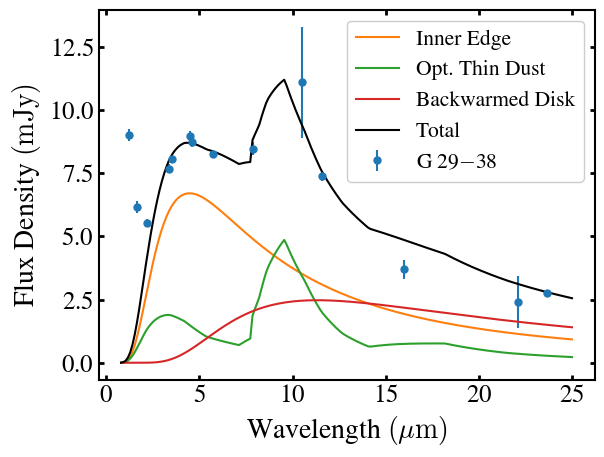

In [247]:
### G 29-38 ###

waves = [1.25, 1.63, 2.19, 3.35, 3.55, 4.49, 4.60, 5.73, 7.87, 10.50, 11.60, 16.0, 22.10, 23.68]
fluxes = [9.00, 6.15, 5.55, 7.68, 8.08, 8.99, 8.73, 8.27, 8.48, 11.1, 7.39, 3.7, 2.4, 2.75]
flux_errs = [0.24, 0.24, 0.16, 0.17, 0.15, 0.19, 0.17, 0.11, 0.24, 2.2, 0.2, 0.37, 1.02, 0.05]

plt.errorbar(waves, fluxes, flux_errs, ls = 'None', marker = 'o', ms = 5, label = r'G 29$-$38')

### Caluculate the Emission from dust
qabs_draine = pd.read_csv('draine_silicate_qabs_1micron.csv')

waves = np.linspace(0.8, 25.0, 200)

f = scipy.interpolate.interp1d(qabs_draine.x.values, qabs_draine[' y'].values, kind='linear')
qabs_waves = f(1.0/waves)

bb = models.BlackBody(temperature=Ts*u.K)
bb_intens = bb(waves*u.micron).value

flux_front_halo = (N_dust_thin_front_halo_ir_corr + N_dust_thin_upper_layers) * (qabs_waves * np.pi*(rgrain**2)) * 1e26 * bb_intens / (d**2)

### Calculate emission from Inner rim

Theta = np.arctan(hz/a)*180.0/np.pi

flux_inner_edge = disk_inner_edge(11000, Theta, 30, d/pc, wave = waves, Trim = Ts, Rwd = 0.012, Rrim = 100)


### Flux from the backwarmed disk

bb = models.BlackBody(temperature=450*u.K)
inten_lambda = bb(waves*u.micron).value
thetas_rad = 30.0*np.pi/180.0


factor1 = 2*a/(d**2)
factor2 = inten_lambda
factor3_1 = np.pi*Deltaa*np.cos(thetas_rad)
factor3_2 = 2*hz*np.sin(thetas_rad)

flux_backwarmed = factor1*factor2*(factor3_1 + factor3_2)*1e26



### Total Flux

total_flux = flux_front_halo + flux_inner_edge + flux_backwarmed

## Plot it

plt.plot(waves, flux_inner_edge, label = 'Inner Edge')
plt.plot(waves, flux_front_halo, label = 'Opt. Thin Dust')
plt.plot(waves, flux_backwarmed, label = 'Backwarmed Disk')
plt.plot(waves, total_flux, c='k', label = 'Total')

plt.gca().tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
plt.gca().tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

plt.gca().set_ylabel(r'Flux Density $\rm (m Jy)$', fontsize = 20)
plt.gca().set_xlabel(r'Wavelength $\rm (\mu m)$', fontsize = 20)

plt.legend(loc = 'upper right', fontsize = 15.5, framealpha = 1)

#plt.savefig('./G2938_sed.png', bbox_inches='tight', dpi = 200)